In [1]:
import nibabel as nib
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from skimage.transform import rotate
import random
from scipy.ndimage import rotate, shift

In [2]:
def calculate_label(image, threshold=0.005):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image == 1) and non_black_ratio >= threshold:
        return True
    else:
        return False

# Função que carrega os dados com pares de imagens
def load_data_with_pairs(folder):
    if not os.path.exists(folder):
        print(f"A pasta {folder} não existe.")
        return {}, {}, {}, {}, {}

    images_by_group = {}
    mask_by_group = {}
    patient_ids = []

    # Itera sobre os pacientes no diretório
    for patient_id in tqdm(os.listdir(folder), desc="Carregamento de arquivos NIfTI..."):
        patient_path = os.path.join(folder, patient_id)

        areas_image = ["left", "right"]
        areas_mask = ["lesion_left", "lesion_right"]
        side_path_left = os.path.join(patient_path, areas_image[0])
        side_path_right = os.path.join(patient_path, areas_image[1])
        lesion_path_left = os.path.join(patient_path, areas_mask[0])
        lesion_path_right = os.path.join(patient_path, areas_mask[1])

        if patient_id not in images_by_group:
            images_by_group[patient_id] = {}
        if patient_id not in mask_by_group:
            mask_by_group[patient_id] = {}
        for type_image, type_mask in zip(areas_image, areas_mask):
            if type_image not in images_by_group[patient_id]:
                images_by_group[patient_id][type_image] = []
            if type_mask not in mask_by_group[patient_id]:
                mask_by_group[patient_id][type_mask] = []
            
            # Carrega as imagens e máscaras do lado esquerdo
            for patch_id, mask_id in zip(os.listdir(side_path_left), os.listdir(lesion_path_left)):
                img_path= os.path.join(side_path_left, patch_id)
                mask_path = os.path.join(lesion_path_left, mask_id)
                for img_path_left, mask_path_left in zip(os.listdir(img_path), os.listdir(mask_path)):
                    image_data_left = nib.load(os.path.join(img_path, img_path_left)).get_fdata()
                    mask_data_left = nib.load(os.path.join(mask_path, mask_path_left)).get_fdata()

                    images_by_group[patient_id][type_image].append(image_data_left)
                    mask_by_group[patient_id][type_mask].append(mask_data_left)

            # Carrega as imagens e máscaras do lado direito
            for patch_id, mask_id in zip(os.listdir(side_path_right), os.listdir(lesion_path_right)):
                img_path = os.path.join(side_path_right, patch_id)
                mask_path = os.path.join(lesion_path_right, mask_id)
                for img_path_right, mask_path_right in zip(os.listdir(img_path), os.listdir(mask_path)):
                    image_data_right = nib.load(os.path.join(img_path, img_path_right)).get_fdata()
                    mask_data_right = nib.load(os.path.join(mask_path, mask_path_right)).get_fdata()

                    images_by_group[patient_id][type_image].append(image_data_right)
                    mask_by_group[patient_id][type_mask].append(mask_data_right)
        patient_ids.append(patient_id)

    # Estruturas para armazenar pares de imagens e máscaras (esquerdo e direito (contralateral))
    images_left = {}
    images_right = {}
    mask_left = {}
    mask_right = {}
    labels_pair = {}

    for patient_id in images_by_group.keys():
        images_left[patient_id] = []
        images_right[patient_id] = []
        mask_left[patient_id] = []
        mask_right[patient_id] = []
        labels_pair[patient_id] = []
        
        for patch_left_image, mask_left_image, patch_right_image, mask_right_image in zip(images_by_group[patient_id][list(images_by_group[patient_id].keys())[0]], mask_by_group[patient_id][list(mask_by_group[patient_id].keys())[0]], images_by_group[patient_id][list(images_by_group[patient_id].keys())[1]], mask_by_group[patient_id][list(mask_by_group[patient_id].keys())[1]]):
            images_left[patient_id].append(patch_left_image)
            images_right[patient_id].append(patch_right_image)
            mask_left[patient_id].append(mask_left_image)
            mask_right[patient_id].append(mask_right_image)
            
            # Determina se há lesão na máscara da imagem esquerda e na contralateral direita
            has_lesion_left  = calculate_label(mask_left_image)
            has_lesion_right = calculate_label(mask_right_image)
            
            # Define o label para o par com base na presença de lesão
            if has_lesion_left == False and has_lesion_right == False:
                labels_pair[patient_id].append(0)
            else:
                labels_pair[patient_id].append(1)

    print(f"Total de pacientes: {len(patient_ids)}")
    for patient_id, labels in labels_pair.items():
        print(f"Paciente {patient_id}: Total de pares de recortes: {len(labels)}")

    return images_left, images_right, labels_pair, mask_left, mask_right

In [3]:
def augment_image(image, augment_factor):
    augmented_images = []
    
    for _ in range(augment_factor):
        # Random rotation
        angle = random.uniform(-30, 30)
        rotated_image = rotate(image, angle, reshape=False)

        # Random shift
        shift_values = random.uniform(-5, 5)
        shifted_image = shift(rotated_image, shift_values)
        
        augmented_images.append(shifted_image)
        
    return augmented_images

def augment_data(images_left, images_right, labels, augment_factor):
    if (augment_factor==1):
        return images_left, images_right, labels
    
    augmented_images_left = []
    augmented_images_right = []
    augmented_labels = []
    
    for img_left, img_right, label in zip(images_left, images_right, labels):
        augmented_left = augment_image(img_left, augment_factor)
        augmented_right = augment_image(img_right, augment_factor)
        
        augmented_images_left.extend(augmented_left)
        augmented_images_right.extend(augmented_right)
        augmented_labels.extend([label] * augment_factor)
        
    return (augmented_images_left), (augmented_images_right), (augmented_labels)

In [4]:
# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = []
    selected_images_opposite = []
    selected_labels = []
    
    for patient in patients:
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original.extend(all_images_original[patient])
            selected_images_opposite.extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return (selected_images_original), (selected_images_opposite), (selected_labels)

In [35]:
# Função para preparar os dados para treino, validação e teste
def prepare_data_for_training_balanced(images_left, images_right, labels_pair, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_original = {}
    balanced_images_opposite = {}
    balanced_labels = {}
    balanced_mask_original = {}
    balanced_mask_opposite = {}

    for patient_id in images_left:
        class_1_labels = []
        class_0_labels = []
        class_1_left = {}
        class_0_left = {}
        class_1_right = {}
        class_0_right = {}
        class_1_mask_left = {}
        class_0_mask_left = {}
        class_1_mask_right = {}
        class_0_mask_right = {}
        
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        index = 0
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels
        for label in labels_pair[patient_id]:
            image_left = (images_left[patient_id])[index]
            image_right = (images_right[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_right[patient_id].append(image_right)
                class_1_mask_left[patient_id].append(mask_image_left)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_right[patient_id].append(image_right)
                class_0_mask_left[patient_id].append(mask_image_left)
                class_0_mask_right[patient_id].append(mask_image_right)
        
        class_1_count = len(class_1_labels)
        if (class_1_count<=1):
            continue
        print(f"Paciente {patient_id}: Total de pares de recortes com labels 1: {class_1_count}")

        # Fazer undersampling da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        class_0_count = len(class_0_labels)
        if class_0_count > class_1_count:
            sampled_class_0_slices_left = (class_0_left[patient_id])[:class_1_count]
            sampled_class_0_slices_right = (class_0_right[patient_id])[:class_1_count]
            class_0_original_modified = {}
            class_0_original_modified[patient_id] = []
            class_0_opposite_modified = {}
            class_0_opposite_modified[patient_id] = []
            sampled_class_0_mask_left = (class_0_mask_left[patient_id])[:class_1_count]
            sampled_class_0_mask_right = (class_0_mask_right[patient_id])[:class_1_count]
            class_0_mask_original_modified = {}
            class_0_mask_original_modified[patient_id] = []
            class_0_mask_opposite_modified = {}
            class_0_mask_opposite_modified[patient_id] = []
            
            for left_image, left_mask in zip(sampled_class_0_slices_left, sampled_class_0_mask_left):
                class_0_original_modified[patient_id].append(left_image)
                class_0_mask_original_modified[patient_id].append(left_mask)
            for right_image, right_mask in zip(sampled_class_0_slices_right, sampled_class_0_mask_right):
                class_0_opposite_modified[patient_id].append(right_image)
                class_0_mask_opposite_modified[patient_id].append(right_mask)
            class_0_labels = [0] * class_1_count

        balanced_images_original[patient_id] = list(class_1_left[patient_id]) + list(class_0_original_modified[patient_id])
        balanced_images_opposite[patient_id] = list(class_1_right[patient_id]) + list(class_0_opposite_modified[patient_id])
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_original[patient_id] = list(class_1_mask_left[patient_id]) + list(class_0_mask_original_modified[patient_id])
        balanced_mask_opposite[patient_id] = list(class_1_mask_right[patient_id]) + list(class_0_mask_opposite_modified[patient_id])

    for patient_id, images in balanced_images_original.items():
        print(f"Paciente {patient_id}: Total de pares de recortes (label 1 + label 0): {len(images)}")
        
    # Separar os dados por conjunto (treino, validação, teste)
    #patients = list(set(balanced_labels.keys()))
    #train_patients, valtest_patients = train_test_split(patients, train_size = train_size)
    #val_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))
    train_patients = ['sub-00043', 'sub-00116', 'sub-00016', 'sub-00090', 'sub-00055', 'sub-00032', 'sub-00138']
    val_patients = ['sub-00063', 'sub-00010', 'sub-00004']
    test_patients = ['sub-00065', 'sub-00064', 'sub-00040']
        
    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(val_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    mask_test_original, mask_test_opposite, _ = select_by_patients(test_patients, balanced_mask_original, balanced_mask_opposite, balanced_labels)

    # Aplicar data augmentation nas imagens
    X_train_original_, X_train_opposite_, y_train = augment_data(X_train_original, X_train_opposite, y_train, augment_factor=augment_factor)
    X_val_original_, X_val_opposite_, y_val = augment_data(X_val_original, X_val_opposite, y_val, augment_factor=augment_factor)
    X_test_original_, X_test_opposite_, y_test = augment_data(X_test_original, X_test_opposite, y_test, augment_factor=augment_factor)
    
    X_train_original_ = [img for img in X_train_original_ if len(img)>0 and img is not []]
    X_train_opposite_ = [img for img in X_train_opposite_ if len(img)>0 and img is not []]

    print(f"Total de pares de recortes no treino ({augment_factor}*{train_patients}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{train_patients}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{val_patients}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{val_patients}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{test_patients}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{test_patients}) label 0: {y_test.count(0)}")
    
    return np.array(X_train_original_), np.array(X_train_opposite_), np.array(X_val_original_), np.array(X_val_opposite_), np.array(X_test_original_), np.array(X_test_opposite_), np.array(y_train), np.array(y_val), np.array(y_test), np.array(X_test_original), np.array(X_test_opposite), np.array(mask_test_original), np.array(mask_test_opposite)

In [6]:
# Função para construir o modelo CNN 2D
def build_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), data_format="channels_last", activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3,3)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(64, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3,3)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(128, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3,3))) 
    model.add(layers.Dropout(0.5)) 
    
    model.add(layers.Conv2D(256, (3,3), padding="same", data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3,3), padding="same")) 
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))

    return model

In [7]:
# Função para construir a rede siamesa
def build_siamese_model(input_shape_original, input_shape_opposite):
    input_original = Input(shape=input_shape_original)
    input_opposite = Input(shape=input_shape_opposite)

    cnn_model = build_cnn_model(input_shape_original)
    output_original = cnn_model(input_original)
    cnn_model_opposite = build_cnn_model(input_shape_opposite)
    output_opposite = cnn_model_opposite(input_opposite)

    # Concatenar as duas saídas (Lado esquerdo + Contra-lateral)
    concatenated = layers.Concatenate()([output_original, output_opposite])
    concatenated = layers.BatchNormalization()(concatenated)
    
    output = layers.Dense(1, activation='sigmoid')(concatenated)
    
    siamese_model = Model(inputs=[input_original, input_opposite], outputs=output)
    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

    return siamese_model

In [8]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [9]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [10]:
input_folder = 'Contralateral'

# Carregar os dados
X_left, X_right, y, mask_left, mask_right = load_data_with_pairs(input_folder)

Carregamento de arquivos NIfTI...: 100%|██████████| 49/49 [05:28<00:00,  6.69s/it]


Total de pacientes: 49
Paciente sub-00001: Total de pares de recortes: 600
Paciente sub-00003: Total de pares de recortes: 552
Paciente sub-00004: Total de pares de recortes: 352
Paciente sub-00009: Total de pares de recortes: 528
Paciente sub-00010: Total de pares de recortes: 600
Paciente sub-00014: Total de pares de recortes: 400
Paciente sub-00015: Total de pares de recortes: 368
Paciente sub-00016: Total de pares de recortes: 576
Paciente sub-00020: Total de pares de recortes: 592
Paciente sub-00024: Total de pares de recortes: 520
Paciente sub-00032: Total de pares de recortes: 512
Paciente sub-00038: Total de pares de recortes: 656
Paciente sub-00040: Total de pares de recortes: 32
Paciente sub-00043: Total de pares de recortes: 224
Paciente sub-00047: Total de pares de recortes: 560
Paciente sub-00055: Total de pares de recortes: 576
Paciente sub-00058: Total de pares de recortes: 408
Paciente sub-00060: Total de pares de recortes: 192
Paciente sub-00063: Total de pares de reco

In [36]:
# Preparar dados para treino, teste e validação
X_train_left, X_train_right, X_valid_left, X_valid_right, X_test_left, X_test_right, y_train, y_valid, y_test, X_test_left_sem_data_augment, X_test_right_sem_data_augment, mask_left_test, mask_right_test = prepare_data_for_training_balanced(X_left, X_right, y, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)

# Adiciono camada de cor
X_train_left = np.expand_dims(X_train_left, axis=-1)
X_train_right = np.expand_dims(X_train_right, axis=-1)
X_valid_left = np.expand_dims(X_valid_left, axis=-1)
X_valid_right = np.expand_dims(X_valid_right, axis=-1)
X_test_left = np.expand_dims(X_test_left, axis=-1)
X_test_right = np.expand_dims(X_test_right, axis=-1)

Paciente sub-00004: Total de pares de recortes com labels 1: 10
Paciente sub-00010: Total de pares de recortes com labels 1: 14
Paciente sub-00016: Total de pares de recortes com labels 1: 42
Paciente sub-00032: Total de pares de recortes com labels 1: 26
Paciente sub-00040: Total de pares de recortes com labels 1: 8
Paciente sub-00043: Total de pares de recortes com labels 1: 12
Paciente sub-00055: Total de pares de recortes com labels 1: 30
Paciente sub-00063: Total de pares de recortes com labels 1: 28
Paciente sub-00064: Total de pares de recortes com labels 1: 8
Paciente sub-00065: Total de pares de recortes com labels 1: 12
Paciente sub-00090: Total de pares de recortes com labels 1: 28
Paciente sub-00116: Total de pares de recortes com labels 1: 15
Paciente sub-00138: Total de pares de recortes com labels 1: 35
Paciente sub-00004: Total de pares de recortes (label 1 + label 0): 20
Paciente sub-00010: Total de pares de recortes (label 1 + label 0): 28
Paciente sub-00016: Total de

In [37]:
# Construir e compilar o modelo CNN
input_shape_left = (X_train_left[1].shape)
input_shape_right = (X_train_right[1].shape)

siamese_model = build_siamese_model(input_shape_left, input_shape_right)
siamese_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 sequential_8 (Sequential)   (None, 256)                  455552    ['input_9[0][0]']             
                                                                                                  
 sequential_9 (Sequential)   (None, 256)                  455552    ['input_10[0][0]']            
                                                                                            

In [38]:
# Adicionar o callback EarlyStopping e low rate scheduler
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Treinamento do modelo  
history = siamese_model.fit([X_train_left, X_train_right], y_train, validation_data=([X_valid_left, X_valid_right], y_valid), batch_size=64, epochs=120)

Epoch 1/120
6/6 [==============================] - 4s 218ms/step - loss: 0.9097 - accuracy: 0.4574 - precision: 0.4612 - recall: 0.5053 - val_loss: 0.6941 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/120
6/6 [==============================] - 1s 147ms/step - loss: 0.7581 - accuracy: 0.6170 - precision: 0.6264 - recall: 0.5798 - val_loss: 0.6969 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/120
6/6 [==============================] - 1s 150ms/step - loss: 0.6110 - accuracy: 0.6995 - precision: 0.7219 - recall: 0.6489 - val_loss: 0.7090 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/120
6/6 [==============================] - 1s 152ms/step - loss: 0.6421 - accuracy: 0.6729 - precision: 0.7019 - recall: 0.6011 - val_loss: 0.7312 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/120
6/6 [==============================] - 1s 148ms/step - loss: 0.6

In [14]:
# Avaliar o modelo
y_pred = (siamese_model.predict([X_test_left, X_test_right]) >=  0.5)

# Gerar o relatório de classificação
print(classification_report(y_test, y_pred))

25/25 [==============================] - 1s 24ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       400
           1       1.00      0.00      0.00       400

    accuracy                           0.50       800
   macro avg       0.75      0.50      0.34       800
weighted avg       0.75      0.50      0.34       800



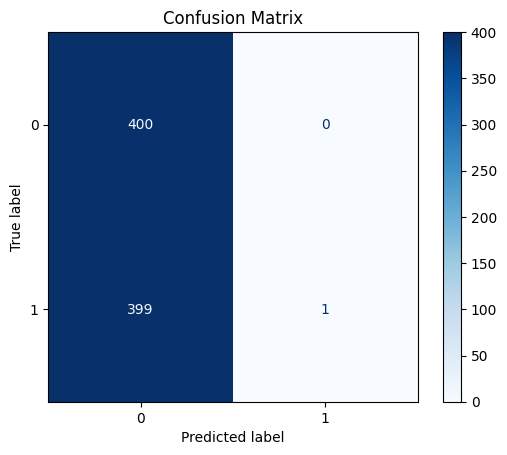

In [15]:
# Gerar a matriz de confusão
plot_confusion_matrix(y_test, y_pred)

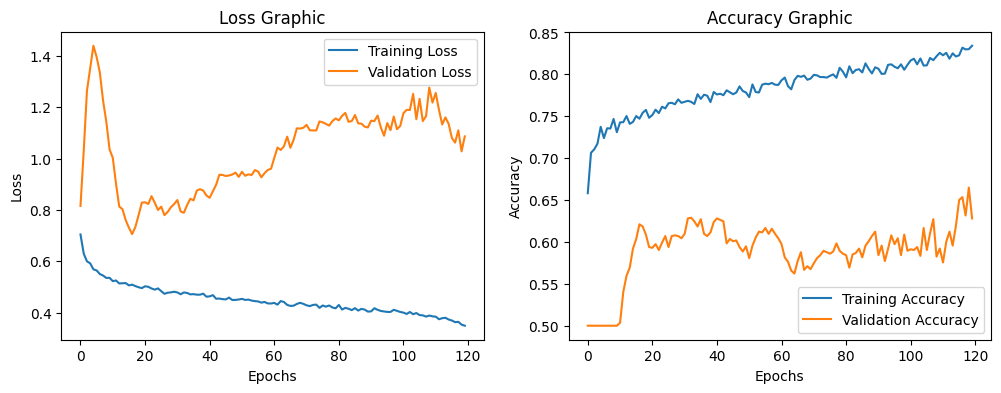

In [16]:
# Plotar o histórico do treinamento
plot_training_history(history)

In [17]:
# Função para plotar e salvar as imagens com legenda no PDF
def plot_images_to_pdf(X_test_left, X_test_right, y_test, y_pred, pdf_path='Pdf/Pacientes_Conjunto_Teste.pdf'):
    contador = 0
    # Abre o arquivo PDF para escrita
    with PdfPages(pdf_path) as pdf:
        for i in range(len(y_test)):
            if y_pred[i] == 1:
                label_pred = "Sim"
            else:
                label_pred = "Não"
            if y_test[i] == 1:
                label_verd = "Sim"
            else:
                label_verd = "Não"
            if (label_pred == "Não" and label_verd == "Sim"):
                if (contador%5 == 0):
                    # Exibe progresso
                    print(f"Processando imagem {i + 1} de {len(y_pred)}")

                    # Configuração da figura
                    fig, axs = plt.subplots(1, 2, figsize=(4, 4))
                    #fig.suptitle(f'Label Pred.: {label_pred}  -  Label Verd.: {label_verd}')

                    # Exibe as imagens
                    axs[0].imshow(X_test_left[i], cmap='gray')
                    axs[0].set_title('MRI Esquerda')
                    axs[0].axis('off')

                    axs[1].imshow(X_test_right[i], cmap='gray')
                    axs[1].set_title('MRI Direita')
                    axs[1].axis('off')

                    # Adiciona a figura atual ao PDF
                    pdf.savefig(fig)
                    plt.close(fig)
                contador+=1

    print(f"As imagens foram salvas no arquivo PDF '{pdf_path}' com sucesso.")

# Chame a função com seus dados
plot_images_to_pdf(X_test_left, X_test_right, y_test, y_pred)

Processando imagem 1 de 800
Processando imagem 7 de 800
Processando imagem 12 de 800
Processando imagem 17 de 800
Processando imagem 22 de 800
Processando imagem 27 de 800
Processando imagem 32 de 800
Processando imagem 37 de 800
Processando imagem 42 de 800
Processando imagem 47 de 800
Processando imagem 52 de 800
Processando imagem 57 de 800
Processando imagem 62 de 800
Processando imagem 67 de 800
Processando imagem 72 de 800
Processando imagem 77 de 800
Processando imagem 82 de 800
Processando imagem 87 de 800
Processando imagem 92 de 800
Processando imagem 97 de 800
Processando imagem 102 de 800
Processando imagem 107 de 800
Processando imagem 112 de 800
Processando imagem 117 de 800
Processando imagem 242 de 800
Processando imagem 247 de 800
Processando imagem 252 de 800
Processando imagem 257 de 800
Processando imagem 262 de 800
Processando imagem 267 de 800
Processando imagem 272 de 800
Processando imagem 277 de 800
Processando imagem 282 de 800
Processando imagem 287 de 800
Pr